# Question 1

## a)

In this part, I will generate 500 data points, with $x$ on the interval $(0, 2\pi)$, and $y_i = 4sin(x_i) + Z_i$, where $Z_i \sim iid \ \ N(0, 1)$.

In [3]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
%matplotlib inline
x = np.linspace(start = 0, stop = 2 * np.pi, num = 500)
y = 4 * np.sin(x) + np.random.normal(loc = 0, scale = 1, size = len(x))



As instructed, I will use Gaussian Kernal in the model. The bandwidth will be evaluated based on cross-validated $L2$ norm.

We can use function `norm.pdf` in the `scipy` package as the kernel function. Note that `norm.pdf`'s standard deviation argument works nicely as the bandwith parameter $\lambda$.

I will set $\lambda$ ranges from .02 to 4, and pick the optimal $\lambda$ value.


In [2]:
lambdas = np.arange(.005, .5, .005)
result = np.empty(len(lambdas) * len(x)).reshape(len(x), len(lambdas))
for i in range(len(x)):
    trainingx = np.delete(x, i)
    trainingy = np.delete(y, i)
    testx = x[i]
    testy = y[i]
    for j in range(len(lambdas)):
        densities = st.norm.pdf(x = trainingx, loc = testx, scale = lambdas[j])
        predicted = sum(trainingy * densities) / sum(densities)
        result[i, j] = (testy - predicted) ** 2

0.16

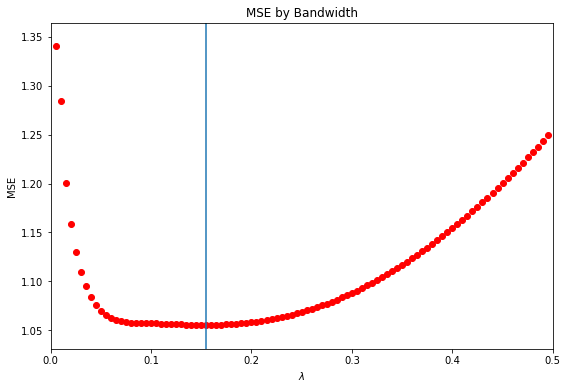

In [3]:
fig, ax = plt.subplots(figsize = (9, 6))
ax.scatter(lambdas, result.mean(0), color = "r", marker = "o")
ax.set_xlabel(r'$ \lambda $')
ax.set_ylabel("MSE")
ax.set_xlim(0, .5, 100)
ax.set_title("MSE by Bandwidth")
ax.axvline(x = lambdas[result.mean(0).argmin()])

plt.plot()
round(lambdas[result.mean(0).argmin()], 2)

The $\lambda$ that achieved the minimum mean square error is $0.15$. Now I am going to plot the predicted value as a line with the true value as points:

[]

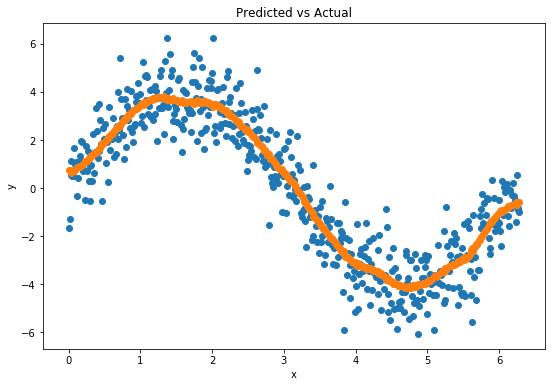

In [4]:
predicted = []
for i in range(len(x)):
    densities = st.norm.pdf(np.delete(x, i), loc = x[i], scale = lambdas[result.mean(0).argmin()])
    predicted.append(sum(np.delete(y, i) * densities) / sum(densities))
fig, ax = plt.subplots(figsize = (9, 6))
ax.scatter(x, y)
ax.scatter(x, predicted)
ax.set_title("Predicted vs Actual")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.plot()


## (b)

In this part, we are going to use a dataset specified by the homework requirement, and implement our algorithm on the real-world data.


In [184]:
videogames = pd.read_csv(r'D:\Zhao\Documents\fall_2017\542\hw4\videogames.csv')
videogames['Logged_Sales'] = np.log(1 + videogames.Global_Sales)


Because we are doing three kernal regression, each on one predictor variable, I will repeat the following procedure three times, each time on one predictor variable:


First, remove observations with missing values, for each of the predictor variable;

Second, find the best bandwidth $\lambda$ with cross validation;

Third, with the best bandwidth, find the MSE.

After all the procedured repeated, I will compare the best MSE across the three models, and decide which predictor variable works the best.

Note that if we want to do leave-one-out-cross-validation, we need to compute density of each of the $n$ points, based on all other $n - 1$ data points, and take the average. Therefore, the time complexity is $O(n^2)$.

If we want to do $k$-fold cross validation, we still need to compute the density of each of the $n$ points, based on all points that are not in the fold, of which there are $\frac{n(k-1)}k$. Therefore, the time complexity is $O(n^2\frac{k-1}k)$.

With thousands of observations, it is still expensive to do even $10$-fold cross validation.

Initially, I was using `R` to implement my algorithm. Due to `R`'s low speed, I had to implement cross-validation like this: I used $k$-fold cross validation. However, each fold will be the training data set, with all observations outside the fold being the testing dataset. That way, we can reduce time complexity to $O(\frac{n^2}k)$. Note that this strategy is different from the usual cross-validation on many other analysis methods. For example, in linear regression, the cross validation is performed in such a way that each fold is a testing dataset, and all observations outside a fold are training dataseet. 

But still the speed is quite slow. Therefore, I decided to use `Python` to implement the algorithm. 

First, we use `Critic_Score` as predictor variable.

In [185]:
c_s = videogames[['Critic_Score', 'Logged_Sales']]
c_s = c_s.dropna()
x = np.array(c_s.Critic_Score)
y = np.array(c_s.Logged_Sales)

In [7]:
lambdas = np.arange(.5, 3, .1)
result = np.empty(len(lambdas) * len(x)).reshape(len(x), len(lambdas))
for i in range(len(x)):
    trainingx = np.delete(x, i)
    trainingy = np.delete(y, i)
    testx = x[i]
    testy = y[i]
    for j in range(len(lambdas)):
        densities = st.norm.pdf(x = trainingx, loc = testx, scale = lambdas[j])
        predicted = sum(trainingy * densities) / sum(densities)
        result[i, j] = (testy - predicted) ** 2

1.2

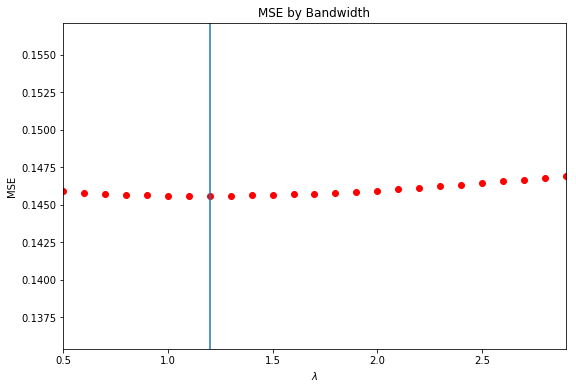

In [8]:
fig, ax = plt.subplots(figsize = (9, 6))
ax.scatter(lambdas, result.mean(0), color = "r", marker = "o")
ax.set_xlabel(r'$ \lambda $')
ax.set_ylabel("MSE")
ax.set_xlim(min(lambdas), max(lambdas))
ax.set_title("MSE by Bandwidth")
ax.axvline(x = lambdas[result.mean(0).argmin()])

plt.plot()
round(lambdas[result.mean(0).argmin()], 3)

Now, I am going to use the obtained optimal bandwidth to fit kernal regression, and get the MSE.

In [9]:
predicted = []
for i in range(len(x)):
    densities = st.norm.pdf(np.delete(x, i), loc = x[i], scale = lambdas[result.mean(0).argmin()])
    predicted.append(sum(np.delete(y, i) * densities) / sum(densities))


0.14560000000000001

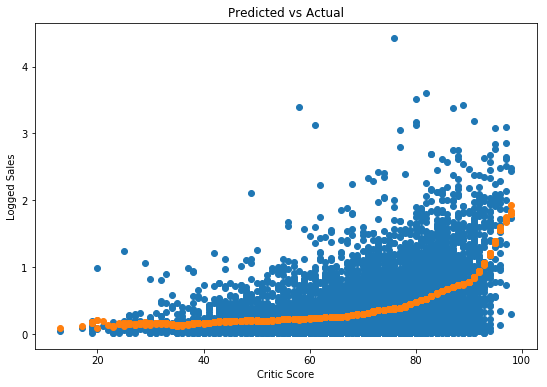

In [10]:
fig, ax = plt.subplots(figsize = (9, 6))
ax.scatter(x, y)
ax.scatter(x, predicted)
ax.set_title("Predicted vs Actual")
ax.set_xlabel("Critic Score")
ax.set_ylabel("Logged Sales")
plt.plot()
round(np.mean((predicted - y) **2), 4)

Second, I will use `Critic_Count` as predictor variable. 

In [11]:
c_c = videogames[['Critic_Count', 'Logged_Sales']]
c_c = c_c.dropna()
x = np.array(c_c.Critic_Count)
y = np.array(c_c.Logged_Sales)

In [12]:
lambdas = np.arange(3, 5, .1)
result = np.empty(len(lambdas) * len(x)).reshape(len(x), len(lambdas))
for i in range(len(x)):
    trainingx = np.delete(x, i)
    trainingy = np.delete(y, i)
    testx = x[i]
    testy = y[i]
    for j in range(len(lambdas)):
        densities = st.norm.pdf(x = trainingx, loc = testx, scale = lambdas[j])
        predicted = sum(trainingy * densities) / sum(densities)
        result[i, j] = (testy - predicted) ** 2

4.0999999999999996

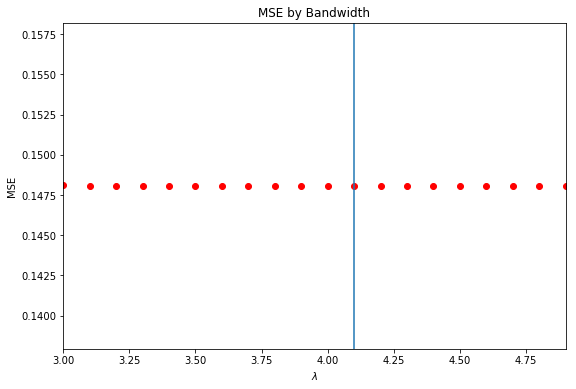

In [13]:
fig, ax = plt.subplots(figsize = (9, 6))
ax.scatter(lambdas, result.mean(0), color = "r", marker = "o")
ax.set_xlabel(r'$ \lambda $')
ax.set_ylabel("MSE")
ax.set_xlim(min(lambdas), max(lambdas))
ax.set_title("MSE by Bandwidth")
ax.axvline(x = lambdas[result.mean(0).argmin()])

plt.plot()
round(lambdas[result.mean(0).argmin()], 2)

In [14]:
predicted = []
for i in range(len(x)):
    densities = st.norm.pdf(np.delete(x, i), loc = x[i], scale = lambdas[result.mean(0).argmin()])
    predicted.append(sum(np.delete(y, i) * densities) / sum(densities))


0.14810000000000001

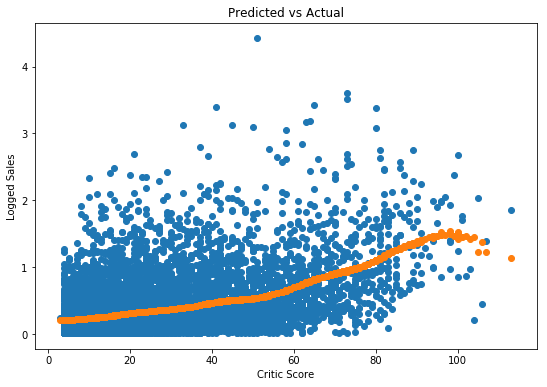

In [15]:
fig, ax = plt.subplots(figsize = (9, 6))
ax.scatter(x, y)
ax.scatter(x, predicted)
ax.set_title("Predicted vs Actual")
ax.set_xlabel("Critic Score")
ax.set_ylabel("Logged Sales")
plt.plot()
round(np.mean((predicted - y) **2), 4)

Last, I will use `User_Score` as predictor variable. 

In [186]:
u_s = videogames[['User_Score', 'Logged_Sales']]
u_s = u_s.dropna()
u_s = u_s[u_s.User_Score != 'tbd']
x = np.array(u_s.User_Score)
x = x.astype(np.float)
y = np.array(u_s.Logged_Sales)

In [187]:
lambdas = np.arange(.02, .5, .02)
result = np.empty(len(lambdas) * len(x)).reshape(len(x), len(lambdas))
for i in range(len(x)):
    trainingx = np.delete(x, i)
    trainingy = np.delete(y, i)
    testx = x[i]
    testy = y[i]
    for j in range(len(lambdas)):
        densities = st.norm.pdf(x = trainingx, loc = testx, scale = lambdas[j])
        predicted = sum(trainingy * densities) / sum(densities)
        result[i, j] = (testy - predicted) ** 2

0.059999999999999998

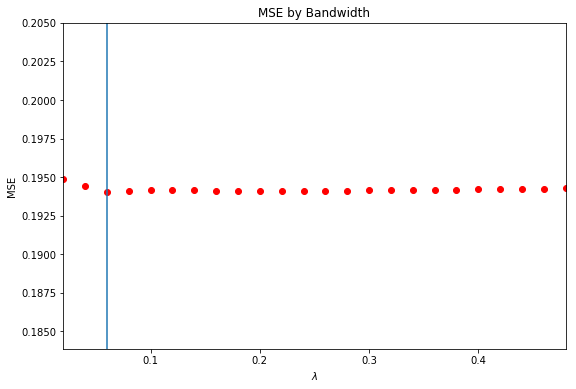

In [188]:
fig, ax = plt.subplots(figsize = (9, 6))
ax.scatter(lambdas, result.mean(0), color = "r", marker = "o")
ax.set_xlabel(r'$ \lambda $')
ax.set_ylabel("MSE")
ax.set_xlim(min(lambdas), max(lambdas))
ax.set_title("MSE by Bandwidth")
ax.axvline(x = lambdas[result.mean(0).argmin()])

plt.plot()
round(lambdas[result.mean(0).argmin()], 2)

In [189]:
predicted = []
for i in range(len(x)):
    densities = st.norm.pdf(np.delete(x, i), loc = x[i], scale = lambdas[result.mean(0).argmin()])
    predicted.append(sum(np.delete(y, i) * densities) / sum(densities))


0.19400000000000001

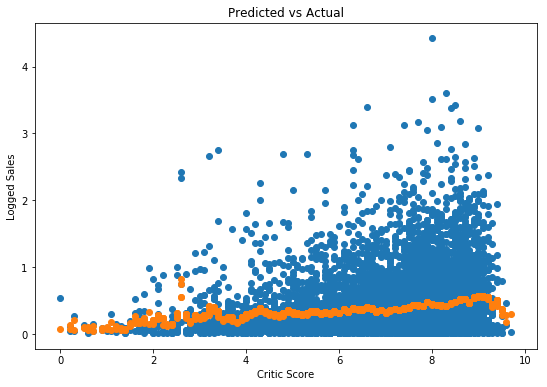

In [190]:
fig, ax = plt.subplots(figsize = (9, 6))
ax.scatter(x, y)
ax.scatter(x, predicted)
ax.set_title("Predicted vs Actual")
ax.set_xlabel("Critic Score")
ax.set_ylabel("Logged Sales")
plt.plot()
round(np.mean((predicted - y) **2), 4)

Among the three models, the model with `Critic_Score` has the lowest mean square prediction error. Therefore, I draw the conclusion that expert critics' opinion is the best indicator of the sales of a game.

# Question 3
## (a)


In [4]:
def CART(x, y, w = []):
    '''
    Takes 3 numpy.array objects x, y, and w. 
    
    Paramters
    ---------
    x: a numpy array containing x values;
    y: a numpy array containing y values, of equal length as x;
    w: a numpy array containing weights, of equal length as x; 
        assumed to be uniformly 1/n if not supplied; normalized if not summing to 1.
    
    
    Returns
    -------
    c: the cutting point.
    fL: prediction of points on the left-hand side of c.
    fR: prediction of points on the right-hand side of c.
    '''
    n = len(x)
    if len(y) != n:
        print('Error: x and y have different lengths.')
        return(None)
    if len(w) != n:
        w = np.ones(n)
            
    w = w / sum(w)
        
    y = [y for _,y in sorted(zip(x,y))]
    y = np.array(y)
    w = [w for _,w in sorted(zip(x,w))]
    w = np.array(w)
    x.sort()
        
    yis1 = (y==1) * 1
        
    scores = np.zeros(n)
    scores[0] = sum(w * yis1) / sum(w) * (1 - sum(w * yis1)) / sum(w) * -sum(w) / sum(w)
    scores[-1] = scores[0]
    for i in range(1, n-1):
        
        pL = sum(w[:i + 1] * yis1[:i + 1]) / sum(w[:i + 1]) 
        pR = sum(w[i + 1:] * yis1[i + 1:]) / sum(w[i + 1:])
            
        giniL = pL * (1 - pL)
        giniR = pR * (1 - pR)
        score = - sum(w[:i]) / sum(w) * giniL - sum(w[i + 1:]) / sum(w) * giniR
        scores[i] = score
        
    maxindex = np.argmax(scores)
    c = x[maxindex]
    pL = sum(w[:maxindex + 1] * yis1[:maxindex + 1]) / sum(w[:maxindex + 1])
    pR = sum(w[maxindex + 1:] * yis1[maxindex + 1:]) / sum(w[maxindex + 1:])
        
    if pL > .5:
        fL = 1
    else:
        fL = -1
    if pR > .5:
        fR = 1
    else:
        fR = -1
    return(c, fL, fR)

Then, I simulated a dataset to test run the algorithm.

In [24]:
 ### do not modify this cell.
n = 1000
x = np.random.uniform(low = 0, high = 1, size = n)
y = 2 * (np.random.binomial(n = 1, p = np.sin(4 * x * np.pi) / 2 + .5, size = n) - .5)
w = np.ones(n) / n

c, fL, fR = CART(x, y)
print(c)
print(fL)
print(fR)

0.231896510466
1
-1


[]

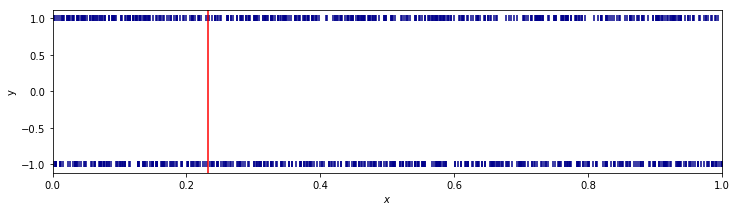

In [25]:
fig, ax = plt.subplots(figsize = (12, 3))
ax.scatter(x, y, color = "darkblue", marker = "|")
ax.set_xlabel(r'$x$')
ax.set_ylabel("y")
ax.set_xlim(0, 1)
ax.axvline(x = c, color = 'r')

plt.plot()

## (b)

In this part, I will write an algorithm that performs adaboost. 

In [26]:
def adaboost(x, y, T):
    '''
    Takes 2 numpy.array objects x, y, and an integer T. 
    
    Paramters
    ---------
    x: a numpy array containing training x values;
    y: a numpy array containing training y values, of equal length as x;
    T: an integer specifying how many iterations are desired.
    
    Returns
    -------
    F: a function that predicts y value. 
    Cuts: a list of floats, each being the cutting point.
    fLs: classification of point if falling on the left of the cutting point.
    fRs: classification of point if falling on the right of the cutting point.
    alpha: alpha value of each iteration.
    '''
    n = len(x)
    if len(y) != n:
        print('Error: x and y have different lengths.')
        return(None)
    y = [y for _,y in sorted(zip(x, y))] 
    y = np.array(y)
    x.sort()
    alpha = np.empty(T)
    cut = np.empty(T)
    fL = np.empty(T)
    fR = np.empty(T)
    
    w = np.empty(n * (T + 1)).reshape(T + 1, n)        
    w[0, :] = 1 / n
    fs = [] # to store the classification rule as functions.
    yis1 = (y==1) * 1
    for t in range(T):
        scores = np.zeros(n)
        scores[0] = - sum(w[t, ] * yis1) / sum(w[t, ]) * (1 - sum(w[t, ] * yis1)) / sum(w[t, ])
        scores[-1] = scores[0]
        for i in range(n - 1):

            pL = sum(w[t, :i + 1] * yis1[:i + 1]) / sum(w[t, :i + 1]) 
            pR = sum(w[t, i + 1:] * yis1[i + 1:]) / sum(w[t, i + 1:])
            
            giniL = pL * (1 - pL)
            giniR = pR * (1 - pR)
            score = - sum(w[t, :i]) / sum(w[t, ]) * giniL - sum(w[t, i + 1:]) / sum(w[t, ]) * giniR
            scores[i] = score
        
        maxindex = np.argmax(scores)
    
        cut[t] = x[maxindex]
        pL = sum(w[t, :maxindex + 1] * yis1[:maxindex + 1]) / sum(w[t, :maxindex + 1])
        pR = sum(w[t, maxindex + 1:] * yis1[maxindex + 1:]) / sum(w[t, maxindex + 1:])
    
        fL[t] = np.sign(sum(w[t, :maxindex + 1] * y[:maxindex + 1]))
        fR[t] = np.sign(sum(w[t, maxindex + 1:] * y[maxindex + 1:]))
        
        predicted_y = np.empty(n)
        predicted_y[:maxindex + 1] = fL[t]
        predicted_y[maxindex + 1:] = fR[t]
    
        indicator = (predicted_y != y) * 1
        epsilon = sum(w[t, ] * indicator)
       
        
        alpha[t] = .5 * np.log((1 - epsilon) / epsilon)
        
              
        w[t + 1, ] = w[t, ] * np.exp(-alpha[t] * y * predicted_y)
        w[t + 1, ] = w[t + 1, ] / sum(w[t + 1, ])
        
    # define F here
    
    def F(test_x):
        classifier = lambda x: np.sign(sum([fL[i] * alpha[i] if x <= cut[i] else fR[i] * alpha[i] for i in range(T)]))        
        test_y = list(map(classifier, test_x))
        return(test_y)
    return(F, cut, fL, fR, alpha)

In [47]:
F, cut, fL, fR, alpha = adaboost(x, y, 30)


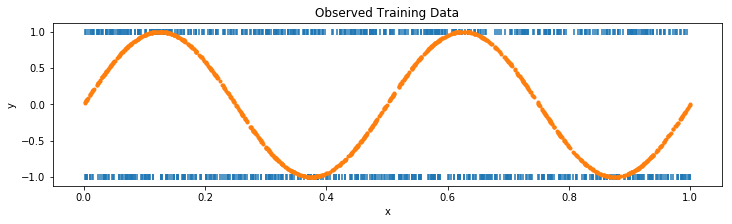

In [48]:
plt.figure(figsize=(12, 3))
plt.scatter(x, y, marker = "|")
plt.scatter(x, np.sin(4 * x * np.pi), marker = ".")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Observed Training Data")


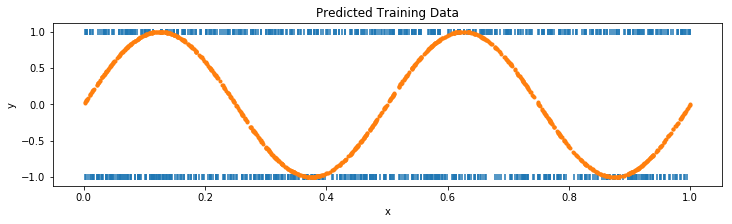

In [44]:
plt.figure(figsize=(12, 3))
plt.scatter(x, F(y), marker = "|")
plt.scatter(x, np.sin(4 * x * np.pi), marker = ".")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Predicted Training Data")

And the prediction accuracy rate is:

In [30]:
np.round(np.mean(y == F(x)), 2)

0.54000000000000004

Now, I will generate an independent data set to test my model.

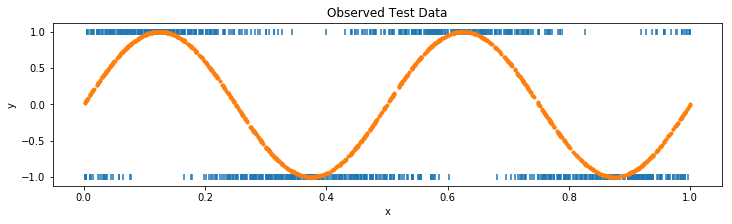

In [45]:
test_y = 2 * (np.random.binomial(n = 1, p = np.sin(4 * x * np.pi) / 2 + .5, size = n) - .5)
plt.figure(figsize=(12, 3))
plt.scatter(x, test_y, marker = "|")
plt.scatter(x, np.sin(4 * x * np.pi), marker = ".")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Observed Test Data")


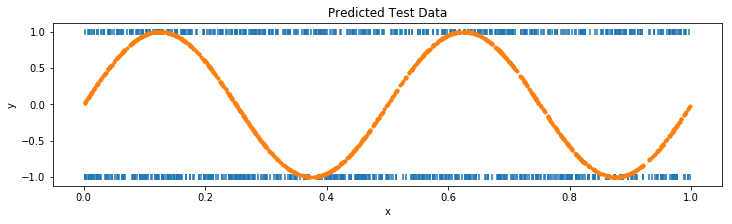

In [46]:
plt.figure(figsize=(12, 3))
plt.scatter(test_x, -np.array(F(x)), marker = "|")
plt.scatter(test_x, np.sin(4 * test_x * np.pi), marker = ".")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Predicted Test Data")


In [43]:
np.mean(test_y == F(test_x))

0.51700000000000002